### *CA3Code - Solving Image Classification Problems with Convolutional Neural Networks* 

### **Import libraries and data for the assessment**

**Libraries for Visualisation**

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

**Libraries for Model Evaluation**

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score, precision_score, f1_score

**Pytorch Libraries for Modelling**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import WeightedRandomSampler, TensorDataset, DataLoader

torch.manual_seed(0)

print('Using PyTorch version', torch.__version__)

Using PyTorch version 1.11.0+cu113


**Import the X-ray Data from Kaggle**

In [ ]:
#We are mounting google drive to have direct access to the data 
#To avoid keep uploading the data file
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install kaggle &> /dev/null

In [ ]:
! mkdir ~/.kaggle &> /dev/null

In [ ]:
! cp /content/drive/MyDrive/CA3/kaggle.json ~/.kaggle/kaggle.json &> /dev/null

In [ ]:
! kaggle datasets download -d prashant268/chest-xray-covid19-pneumonia

100% 2.04G/2.06G [00:50<00:00, 46.8MB/s]
100% 2.06G/2.06G [00:50<00:00, 43.7MB/s]


In [ ]:
! unzip chest-xray-covid19-pneumonia &> /dev/null

### **Data preprocessing & Analysis**

In [ ]:
# Define an image transformer to transform images as specified by PyTorch.
# Height and width are expected to be at least 224 x 224
# Each image needs to be normalised using {mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]}
data_transform = transforms.Compose([
                                        transforms.Resize(256),
                                        transforms.CenterCrop(224),
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                    ])

In [ ]:
# initialise train and test datasets using path from kaggle downloads

train_data = datasets.ImageFolder('Data/train', transform=data_transform)
test_data = datasets.ImageFolder('Data/test', transform=data_transform)

In [ ]:
# create original loaders

train_loader_original = DataLoader(train_data, batch_size = 8, shuffle=True,num_workers=4)
test_loader_original = DataLoader(test_data, batch_size=1, shuffle=False,num_workers=4)

**Visualise the X-ray Images**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


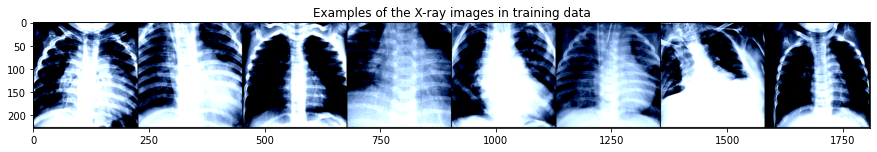

In [ ]:
for images, labels in train_loader_original:
  #Create a grid that contains a batch of images
  imgs_grid = torchvision.utils.make_grid(images, nrow=8)
  plt.figure(figsize=(15,10))
  #Convert the grid to a numpy array and transpose
  plt.imshow(np.transpose(imgs_grid.numpy(), (1, 2, 0)), cmap='gray')
  plt.title("Examples of the X-ray images in training data")
  #We only need one batch of images hence break
  break

In [ ]:
# show unique classes and class mapping
class_names = train_data.classes
print('Class Labels:')
print(class_names)
print('----------------------')
print('Class Mapping:')
print(train_data.class_to_idx)

Class Labels:
['COVID19', 'NORMAL', 'PNEUMONIA']
----------------------
Class Mapping:
{'COVID19': 0, 'NORMAL': 1, 'PNEUMONIA': 2}


In [ ]:
# get class instances for test and train sets to determine potential class imbalance
from collections import Counter

train_instances = dict(Counter(train_data.targets))
print("Train set:\n---------------------------------------------------")
print(train_instances)

test_instances = dict(Counter(test_data.targets))
print("\nTest set:\n---------------------------------------------------")
print(test_instances)

Train set:
---------------------------------------------------
{0: 460, 1: 1266, 2: 3418}

Test set:
---------------------------------------------------
{0: 116, 1: 317, 2: 855}


**Fix Class Imbalance with Oversampling**

In [ ]:
# determine class weights for train data

# total num of instances
samples = len(train_data)
# total num of classes
classes_total = len(train_instances)
# individual instances
class_0 = train_instances[0]
class_1 = train_instances[1]
class_2 = train_instances[2]

# determine weights
class_0_weight = round(samples/(classes_total*class_0), 2)
class_1_weight = round(samples/(classes_total*class_1), 2)
class_2_weight = round(samples/(classes_total*class_2), 2)

print('The weights for unique classes:')
print('Weight for class 0:', class_0_weight)
print('Weight for class 1:', class_1_weight)
print('Weight for class 2:', class_2_weight)

The weights for unique classes:
Weight for class 0: 3.73
Weight for class 1: 1.35
Weight for class 2: 0.5


In [ ]:
# create oversampling function to create more balanced dataset

def get_loader(root_dir, batch_size):
  dataset = datasets.ImageFolder(root = root_dir, transform=data_transform)
  class_weights = [class_0_weight, class_1_weight, class_2_weight]
  sample_weights = [0] * samples

  for idx, (data, label) in enumerate(dataset):
    class_weight = class_weights[label]
    sample_weights[idx] = class_weight

  sampler = WeightedRandomSampler(sample_weights, num_samples = len(sample_weights), replacement = True)
  loader = DataLoader(dataset, batch_size = batch_size, sampler = sampler)

  return loader

def main():
  train_loader_oversampled = get_loader(root_dir = 'Data/train', batch_size = 8)

  num_class_0 = 0
  num_class_1 = 0
  num_class_2 = 0
  for data, labels in train_loader_oversampled:
    num_class_0 += torch.sum(labels == 0)
    num_class_1 += torch.sum(labels == 1)
    num_class_2 += torch.sum(labels == 2)
  print(f"The number of class 0 instances is {num_class_0}")
  print(f"The number of class 1 instances is {num_class_1}")
  print(f"The number of class 2 instances is {num_class_2}")
  return train_loader_oversampled


In [ ]:
# classes are more balanced now
# observe how this affects performances
train_loader_oversampled = main()

The number of class 0 instances is 1685
The number of class 1 instances is 1754
The number of class 2 instances is 1705


In [ ]:
# get test loader
test_loader_oversampled = DataLoader(test_data, batch_size = 1)

### **CA3 PT1 - compare performance of two pretrained CNN models**

In [ ]:
# Define device, use GPU if available, else use CPU
device = torch.device("cuda:0")

In [ ]:
device = torch.device('cpu')

In [ ]:
# First pre-trained model
# Import the pretained VGG16 model
model_vgg16 = models.vgg16(pretrained=True)

# Freeze all parts of the model except the last layer
for param in list(model_vgg16.parameters())[:-1]:
    param.requires_grad = False

# Change the output layer to match our current dataset
model_vgg16.classifier[6] = nn.Linear(4096, len(class_names))
model_vgg16 = model_vgg16.to(device)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [ ]:
# Test vgg16 model
def test_vgg16(dataloader):
  # torch.no_grad as we dont update weights
  with torch.no_grad():
      correct = 0
      
      # Loop through a batch of images and its labels
      for images,labels in dataloader:
        # Make sure they are connected to GPU
        images, labels = images.to(device), labels.to(device)
        # Prediction based on VGG16
        predictions = model_vgg16(images)
        # Get the label with the highest probability
        pred = torch.max(predictions, 1)[1]
        # Count correct predictions
        correct += (pred == labels).sum()
      # Accuracy. 1288 is the size of the testing dataset
      print('Test Set Accuracy : %f'%(correct.item() / 1288))
  
  # Initialise confusion matrix
  cm_var = confusion_matrix(labels.view(-1).to("cpu").numpy(), pred.view(-1).to("cpu").numpy())
  # Convert into dataframe to plot
  cm_df = pd.DataFrame(cm_var, class_names, class_names)
  plt.figure(figsize=(10, 6))
  sns.heatmap(cm_df, annot=True, fmt='d')
  plt.title("Confusion Matrix VGG16 Pretrained")
  plt.xlabel("Predicted Labels", fontsize=12)
  plt.ylabel("Actual Labels", fontsize=12)
  plt.savefig("cm_pretrained_vgg.png", dpi=500)

In [ ]:
# Import pretrained resnet model
model_resnet18 = models.resnet18(pretrained=True)

model_resnet18 = model_resnet18.to(device)
# Freeze all parts of the model except the last layer
for param in list(model_resnet18.parameters())[:-1]:
    param.requires_grad = False

# Change the output layer to match our current dataset
model_resnet18.fc = nn.Linear(512, len(class_names))
model_resnet18 = model_resnet18.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
# Test ResNet18 model
def test_resnet18(dataloader):
  #The code below is identical to test_vgg16 function
  with torch.no_grad():
    correct = 0
    for images,labels in dataloader:
      images, labels = images.to(device), labels.to(device)
      predictions = model_resnet18(images)
      pred = torch.max(predictions, 1)[1]
      correct += (pred == labels).sum()
    print('Test Set Accuracy : %f'%(correct.item() / 1288))

  cm_var = confusion_matrix(labels.view(-1).to("cpu").numpy(), pred.view(-1).to("cpu").numpy())
  cm_df = pd.DataFrame(cm_var, class_names, class_names)
  plt.figure(figsize=(10, 6))
  sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
  plt.title("Confusion Matrix ResNet18 Pretrained")
  plt.xlabel("Predicted Labels", fontsize=12)
  plt.ylabel("Actual Labels", fontsize=12)
  plt.savefig("cm_pretrained_vgg.png", dpi=500)

In [ ]:
test_all_data = DataLoader(test_data, batch_size=1288, shuffle=False)

Test Set Accuracy : 0.652950


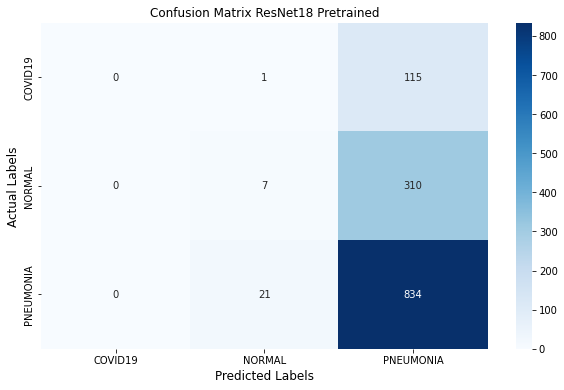

In [ ]:
test_resnet18(test_all_data)

Test Set Accuracy : 0.358696


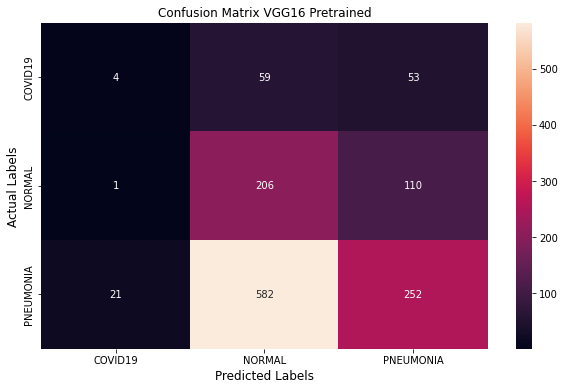

In [ ]:
test_vgg16(test_all_data)

### **CA3 PT2 - Implement our own CNN model**

In [ ]:
# adding layers on top of resnet pretrained model
class ResNetXray(nn.Module):

  #Define the new architecture of CNN
  #For details please refer to the Proposed Network section of the report 
  def __init__(self):
    super().__init__()

    #Import ResNet18 Model to use it as feature extractor
    resnet_model = models.resnet18(pretrained=True)
    #Drop the last two layers
    resnet_model_wo_output = nn.Sequential(*(list(resnet_model.children())[0:8]))

    #The first part of the model is ResNet18 without the last two layers
    self.modifiedresnet = resnet_model_wo_output
    #The first convolutional layer
    self.conv1 = nn.Conv2d(512, 128, 4)
    #The second convolutional layer
    self.conv2 = nn.Conv2d(128, 128, 1)
    #Flatten the input
    self.flatten = nn.Flatten()
    #The first fully-connected layer
    self.fc1 = nn.Linear(128*4*4, 256)
    #The second fully-connected layer
    self.fc2 = nn.Linear(256, 256)
    #Dropout (p=0.2)
    self.dropout = nn.Dropout(0.2)
    #The third fully-connected layer
    self.fc3 = nn.Linear(256, 256)
    #The fourth fully-connected layer
    self.fc4 = nn.Linear(256, 256)
    #The second dropout (p=0.2)
    self.dropout = nn.Dropout(0.2)
    #The last(output) layer
    self.fc5 = nn.Linear(256, 3)
  
  def forward(self, X):
    X = self.modifiedresnet(X)
    X = F.relu(self.conv1(X))
    X = F.relu(self.conv2(X))
    X = self.flatten(X)
    X = F.relu(self.fc1(X))
    X = self.dropout(self.fc2(X))
    X = F.relu(self.fc3(X))
    X = self.dropout(self.fc4(X))
    X = self.fc5(X)
    #For multi-class classification, we use log softmax for the last activation
    X = F.log_softmax(X, dim=1)
    return X

In [ ]:
#Initialise the first model
model = ResNetXray()
model = model.to(device)

In [ ]:
#Define loss function (cross entropy for multi-class classification)
criterion = nn.CrossEntropyLoss()

#Define optimiser for gradient descent. 
optimiser = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
#Function to train and test the models

def train_test_model(train_loader, test_loader, model):

  epochs = 100
  # Track train and test error
  train_losses = []
  test_losses = []
  # Count how many times it made a correct prediciton
  train_num_correct = []
  test_num_correct = []
 
  for i in range(epochs):
    train_correct = 0
    test_correct = 0
    total = 0
    for batch, (image, label) in enumerate(train_loader):

      image, label = image.to(device), label.to(device)
      batch += 1

      # Make a prediction
      y_pred = model(image)

      # Calculate loss
      loss = criterion(y_pred, label)
      
      # Get the label where the probability is the highest
      prediction = torch.max(y_pred.data, 1)[1]

      # How many times it made a correct prediction during the batch
      batch_corr = (prediction == label).sum()
      # Add this to train_correct
      train_correct += batch_corr
      # Number of labels 
      total += label.size(0)
      
      # Optimisation process
      optimiser.zero_grad()
      loss.backward()
      optimiser.step()

    # Print loss and accuracy per epoch
    print(f"EPOCH: {i} LOSS: {loss.item()} ACCURACY: {train_correct.item()*100/(total)}")

    # Append train loss per epoch
    train_losses.append(loss)
    # Append the number of correct predictions per epoch
    train_num_correct.append(train_correct)

    # We are testing at the same time. 
    # Set torch.no_grad as we dont update weights here
    with torch.no_grad():
      # Loop through test data loader
      for batch, (image_test, label_test) in enumerate(test_loader):
        
        image_test, label_test = image_test.to(device), label_test.to(device)

        y_val = (model(image_test))

        prediction = torch.max(y_val.data, 1)[1]

        test_correct += (prediction== label_test).sum()

    loss = criterion(y_val, label_test)

    # Append test loss per epoch
    test_losses.append(loss)
    # Append the number of correct predictions per epoch
    test_num_correct.append(test_correct)

  return train_losses, test_losses, train_num_correct, test_num_correct

**Train and Evaluate Our Own Model on Two Dataloaders (normal & oversampled)**

The First Model (non-oversampled data loader)

In [ ]:
# Train the first model with non-oversampled data loader
train_losses_b8, test_losses_b8, train_num_correct_b8, test_num_correct_b8 = train_test_model(train_loader_original, test_loader_original)

In [ ]:
# Save the model
torch.save(model.state_dict(), 'ResNetXray_batch8.pt')

In [ ]:
# Load the model.
# '8' refers to trained on the batch size of 8
model_8= ResNetXray()
model_8.load_state_dict(torch.load("ResNetXray_batch8.pt"))
model_8.to(device)

In [ ]:
# A function to plot accuracies 
def plot_accuracy(train_num_correct, test_num_correct):

  train_num_correct_list = []
  test_num_correct_list = []
  # The number of correct predictions is stored in a tensor. Convert this to a list
  for point in train_num_correct:
    # item() methods returns python standard number
    # Iterate all values in the tensor and store them in a list
    train_num_correct_list.append(point.item())
  for point in test_num_correct:
    test_num_correct_list.append(point.item())

  plt.figure(figsize=(10, 6))
  #Plot accuracies
  #5114 refers to the size of training data, whereas 1288 is that of testing data
  plt.plot([(x/5114)*100 for x in train_num_correct_list], label='training accuracy')
  plt.plot([(x/1288)*100 for x in test_num_correct_list], label='testing accuracy')
  plt.legend()
  plt.title("Training & Testing Accuracies per Epoch")
  plt.xlabel('Epochs', fontsize=12)
  plt.ylabel('Accuracy', fontsize=12)

In [ ]:
# A function to plot a confusion matrix given a model
def plot_confusion_matrix(data, model):

  # The input data will be the entire testing data
  # We get vectors of labels and preds by feeding the whole data
  # Use these to calculate recall and precision
  with torch.no_grad():
    correct = 0
    for image, label in data:
      image, label = image.to(device), label.to(device)
      y_val = model(image)
      pred = torch.max(y_val, 1)[1]
      correct += (pred == label).sum()

  # Calculate recall & precision with average = 'micro' as the classes are imbalanced
  recall = recall_score(label.view(-1).to("cpu").numpy(), pred.view(-1).to("cpu").numpy(), average='micro')
  precision = precision_score(label.view(-1).to("cpu").numpy(), pred.view(-1).to("cpu").numpy(), average='micro')

  print('Test Accuracy: ', round(correct.item()*100/1288, 3))
  print('Test Recall: {:0.3f}'.format(recall*100))
  print('Test Precision: {:0.3f}'.format(precision*100))

  # Plot a confusion matrix
  arr = confusion_matrix(label.view(-1).to("cpu").numpy(), pred.view(-1).to("cpu").numpy())
  df_arr = pd.DataFrame(arr, class_names, class_names)
  plt.figure(figsize=(9,6))
  sns.heatmap(df_arr, annot=True, fmt='d', cmap='Blues')
  plt.title("Confusion Matrix across three classes")
  plt.xlabel("Predicted Labels", fontsize=12)
  plt.ylabel("Actual Labels", fontsize=12)
  plt.show()

**Plot Training & Testing Accuracy per Epoch of The First Model**

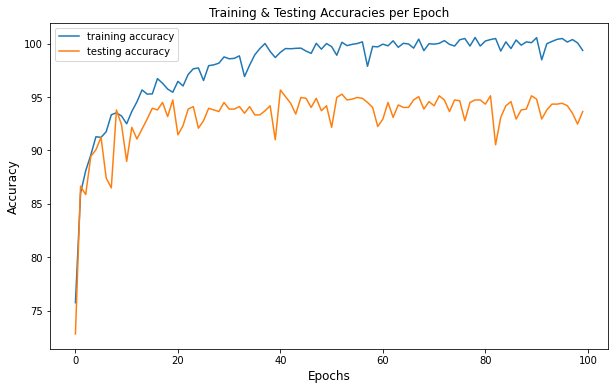

In [ ]:
plot_accuracy(train_num_correct_b8, test_num_correct_b8)

**Plot Confusion Matrix of The First Model**

In [ ]:
test_data_test = DataLoader(test_data, batch_size=1288, shuffle=False)

Test Accuracy:  93.245
Test Recall: 93.245
Test Precision: 93.245


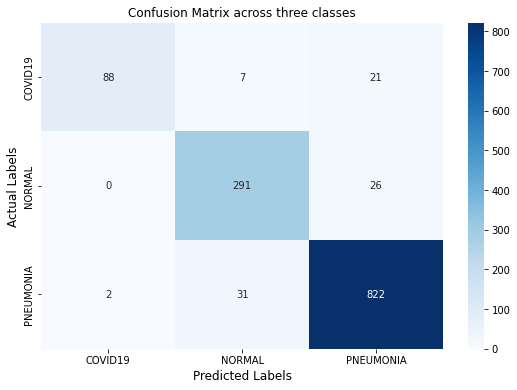

In [ ]:
#Accuracy, recall & precision are identical as its micro averaged
plot_confusion_matrix(test_all_data, model_8)

The Second Model (with oversampled data loader)

In [ ]:
# Initialise the model
model_oversampled = ResNetXray()
model_oversampled = model_oversampled.to(device)

In [ ]:
#Define loss function (cross entropy for multi-class classification)
criterion = nn.CrossEntropyLoss()

#Define optimiser for gradient descent. 
optimiser = torch.optim.Adam(model_oversampled.parameters(), lr=0.001)

In [ ]:
# Train the oversampled model
tr_loss, te_loss, tr_correct, te_correct  = train_test_model(train_loader_oversampled, test_loader_oversampled, model_oversampled)

EPOCH: 0 LOSS: 0.07218798249959946 ACCURACY: 78.1298600311042
EPOCH: 1 LOSS: 0.33577650785446167 ACCURACY: 87.57776049766719
EPOCH: 2 LOSS: 0.2069413661956787 ACCURACY: 90.45489891135303
EPOCH: 3 LOSS: 0.3935941457748413 ACCURACY: 91.60186625194402
EPOCH: 4 LOSS: 0.4061446189880371 ACCURACY: 91.93234836702955
EPOCH: 5 LOSS: 0.03638295829296112 ACCURACY: 93.7597200622084
EPOCH: 6 LOSS: 0.0580751970410347 ACCURACY: 92.41835147744946
EPOCH: 7 LOSS: 0.005519975908100605 ACCURACY: 94.18740279937792
EPOCH: 8 LOSS: 0.002713861409574747 ACCURACY: 94.2846034214619
EPOCH: 9 LOSS: 0.0714043378829956 ACCURACY: 96.44245723172628
EPOCH: 10 LOSS: 0.16410066187381744 ACCURACY: 95.39269051321928
EPOCH: 11 LOSS: 0.7915612459182739 ACCURACY: 95.74261275272161
EPOCH: 12 LOSS: 0.015616321004927158 ACCURACY: 96.03421461897356
EPOCH: 13 LOSS: 0.0667990893125534 ACCURACY: 96.03421461897356
EPOCH: 14 LOSS: 0.029943494126200676 ACCURACY: 95.52877138413686
EPOCH: 15 LOSS: 0.005298975855112076 ACCURACY: 96.306376

In [ ]:
# Save the model
torch.save(model_oversampled.state_dict(), 'ResNetXray_oversampled.pt')

In [ ]:
# Load the model
model_oversampled= ResNetXray()
model_oversampled.load_state_dict(torch.load("ResNetXray_oversampled.pt"))
model_oversampled.to(device)

**Plot Training & Testing Accuracy per Epoch of The Second Model**

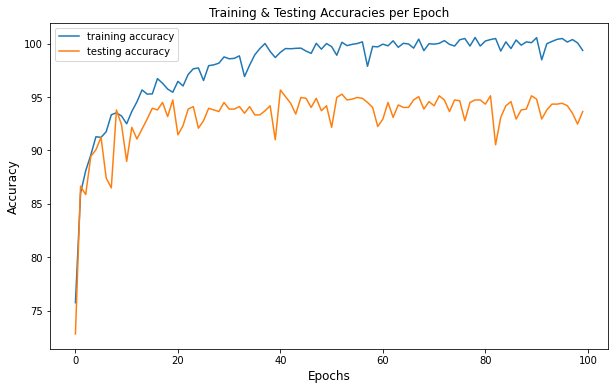

In [ ]:
plot_accuracy(tr_correct, te_correct)

**Plot Confusion Matrix of The Second Model**

In [ ]:
# Note: test data was not oversampled
test_data_test = DataLoader(test_data, batch_size=1288, shuffle=False)

Test Accuracy:  94.41
Test Recall: 94.410
Test Precision: 94.410


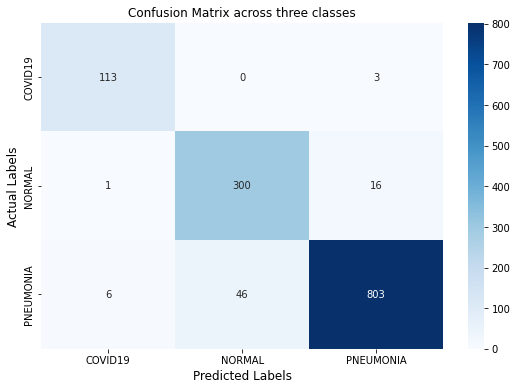

In [ ]:
plot_confusion_matrix(test_all_data, model_oversampled)

### *CA3CODE - END*